# Keldy: Playground

## Imports & Setup Properties

In [1]:
import os
import sys
import glob
import copy
import itertools

import h5py

import math
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import scipy.integrate
import mpi4py

### Plotting

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [3]:
#Plotting Options
markslist='o^v<>dhps*HD'
cmap = plt.get_cmap('plasma')
color_list_limit = 2

def f_colorlist(i, offset = 0, cycle = color_list_limit):
    return cmap(float((i+offset)%cycle) / cycle)

def f_markslist(i, offset = 0, cycle = color_list_limit):
    return markslist[((i+offset)%cycle)]

### Keldy Import

In [4]:
from pytriqs.gf import *
from pytriqs.plot.mpl_interface import oplot,plt

import keldy.impurity_oneband_module as k_imp

## Model g0

In [5]:
anderson_param = {
    "beta": 10000.0, 
    "bias_V" : 0.0,
    "eps_d": -0.0,
    "Gamma": 0.25,
    "time_max": +500.0,
    "nr_time_points_gf": 10000,
    "bath_type": "semicircle"
}

In [6]:
g0 = k_imp.G0Model(**anderson_param)

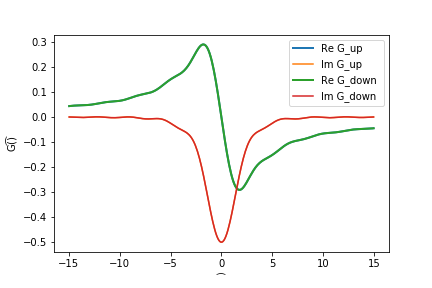

In [7]:
oplot(g0.g0_greater, '-', linewidth=2, x_window=(-15,15)) 

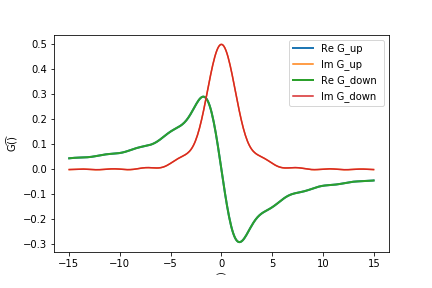

In [8]:
oplot(g0.g0_lesser, '-', linewidth=2, x_window=(-15,15)) 

### Keldysh Adaptor

In [9]:
g0K = k_imp.G0KeldyshContourT(g0)

In [10]:
# g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 0))

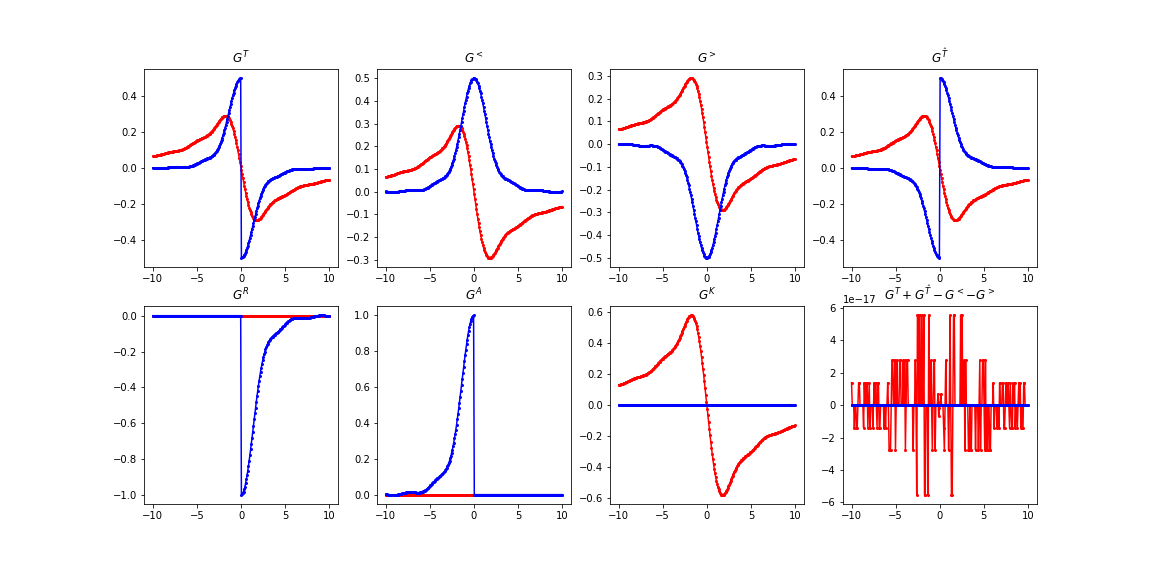

In [11]:
fig = plt.figure(figsize=(16,8))

t = np.linspace(-10,10,250)

g_ff = np.zeros(len(t), dtype='c16')
g_fb = np.zeros(len(t), dtype='c16')
g_bf = np.zeros(len(t), dtype='c16')
g_bb = np.zeros(len(t), dtype='c16')
gR = np.zeros(len(t), dtype='c16')
gA = np.zeros(len(t), dtype='c16')
gK = np.zeros(len(t), dtype='c16')
g_cancel = np.zeros(len(t), dtype='c16')

for i in range(len(t)):
    g_ff[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 0), True) 
    g_fb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 1), True) 
    g_bf[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 0), True) 
    g_bb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 1), True) 

    gR[i]  = g_ff[i] - g_fb[i]
    gA[i]  = g_ff[i] - g_bf[i]
    gK[i]  = g_ff[i] + g_bb[i]
    
    g_cancel[i] = g_ff[i] + g_bb[i] - g_bf[i] - g_fb[i]

plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
for (i_p, (fun, label)) in enumerate(plt_list):
    ax0 = plt.subplot(2,4,i_p + 1)
    ax0.plot(t, fun.real, marker='o', markersize=2, color='red')
    ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
    ax0.set_title(label)
#     ax0.set_scale.

plt.show()

In [12]:
# fig = plt.figure(figsize=(16,8))

# plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
# for (i_p, (fun, label)) in enumerate(plt_list):
#     ax0 = plt.subplot(2,4,i_p + 1)
#     ax0.plot(t, np.abs(fun) / np.abs(g_fb + g_bf), marker='o', markersize=2, color='red')
# #     ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
#     ax0.set_title(label)
# #     ax0.set_scale.

# plt.show()

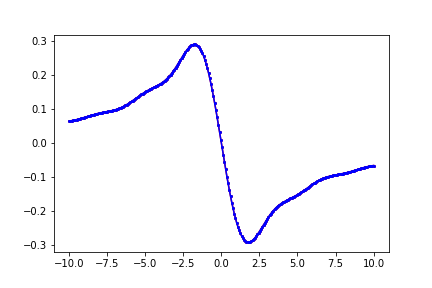

In [13]:
fig = plt.figure()
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_fb.real, marker='o', markersize=2, color='red')
ax0.plot(t, g_bf.real, marker='o', markersize=2, color='blue')




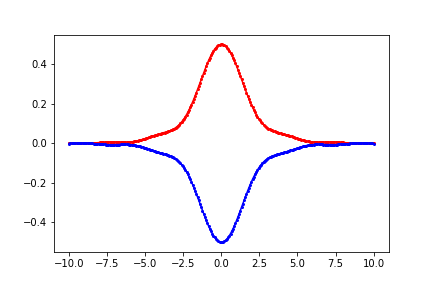

In [14]:
fig = plt.figure()
ax0 = plt.subplot(1,1,1)
ax0.plot( t, g_fb.imag, marker='o', markersize=2, color='red')
ax0.plot(t, g_bf.imag, marker='o', markersize=2, color='blue')





## Wick

In [15]:
kp_ext_1 =  k_imp.GfIndexT(10.0, 0, 0)
kp_ext_2 =  k_imp.GfIndexT(10.0, 0, 1)

my_integrand =  k_imp.IntegrandGT1t2Direct(g0K, kp_ext_1, kp_ext_2)

### Order 0 Calculation

In [16]:
# Numerics
t = np.linspace(0.0,10.0,100)
t_list = [list([]) for t0 in t]
g_order0 = np.array(map(my_integrand, t_list))

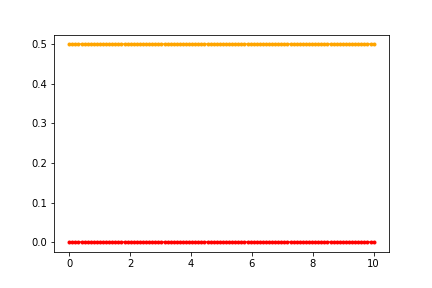

In [17]:
plt.plot(t, g_order0.real, marker='o', markersize=3, color='red')
plt.plot(t, g_order0.imag, marker='o', markersize=3, color='orange')
plt.show()

### Order 1 Calculation

In [18]:
my_integrand([0.00])

(-0.00014654082276309357+1.1518563880486e-15j)

In [19]:
t = np.linspace(0.0,10.0,500)
t_list = [list([t0]) for t0 in t]
g_order1 = np.array(map(my_integrand, t_list))

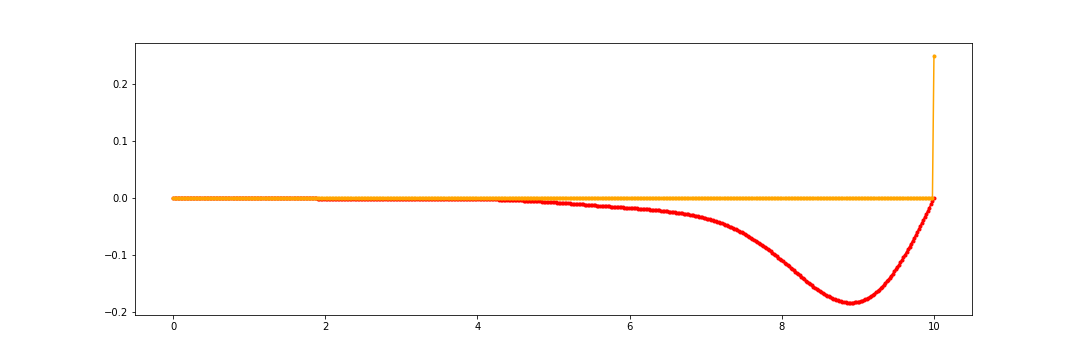

In [20]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_order1.real, marker='o', markersize=3, color='red')
ax0.plot(t, g_order1.imag, marker='o', markersize=3, color='orange')
# ax0.plot(t, np.abs(g_order1), marker='o', markersize=3, color='blue')


# ax1.set_yscale('log')
plt.show()

In [21]:
result_sp = sp.integrate.romberg(lambda x: my_integrand([x]).real, 0, 10)
print(result_sp)

-0.37765874446567643


/usr/local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:752: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.122741e-07
  AccuracyWarning)


In [22]:
t_max = 10.0

def f1_w(t):
    return 1e-12 + np.abs(my_integrand([t_max - t]))

my_w = k_imp.WarperPlasmaSimpleT(f1_w, t_max, 1000)

In [23]:
t = np.linspace(0.0,10.0,500)
t_list = [list([t0]) for t0 in t]
g_order1_w = np.array(map(my_w.evaluate_warping_function, t_list))

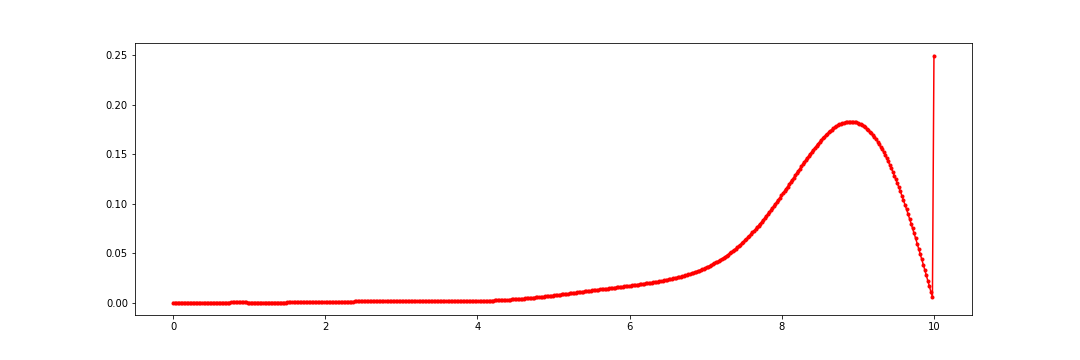

In [24]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_order1_w, marker='o', markersize=3, color='red')
# ax1.set_yscale('log')
plt.show()

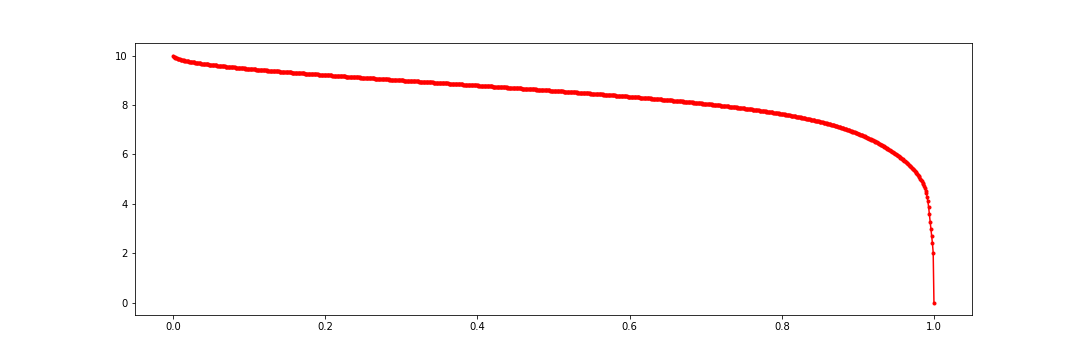

In [25]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)


l = np.linspace(0.0,1.0,1000)
l_list = [list([l0]) for l0 in l]

ax0.plot(l, np.array(map(my_w.ui_from_li, l_list)), marker='o', markersize=3, color='red')
# ax1.set_yscale('log')
plt.show()



### Order 2 Calculation

In [26]:
# fig = plt.figure(figsize=(15,5))
# ax0 = plt.subplot(1,1,1)
# ax0.plot(t, g_order2.real, marker='o', markersize=3, color='red')
# ax0.plot(t, g_order2.imag, marker='o', markersize=3, color='orange')

# # ax1.set_yscale('log')
# plt.show()

In [27]:
u_list_p = []
u_list = []
v_list = []

nr_sample_edge = 250
delta_t = t_max / nr_sample_edge

for i_t1 in range(nr_sample_edge):
    for i_t2 in range(i_t1 - 2):
        u_list_p.append(k_imp.ui_from_vi(t_max, k_imp.vi_from_ui(t_max, [delta_t * i_t1, delta_t * i_t2])))
        v_list.append(k_imp.vi_from_ui(t_max, [delta_t * i_t1, delta_t * i_t2]))
        u_list.append([delta_t * i_t1, delta_t * i_t2])


g_order2   = np.array(map(my_integrand, u_list))
g_order2_w = np.array(map(my_w.evaluate_warping_function, u_list))

In [28]:
## SciPy Integrae

>>> from scipy import integrate
>>> def f(x, y):
...     return x*y
...
>>> def bounds_y():
...     return [0, 0.5]
...
>>> def bounds_x(y):
...     return [0, 1-2*y]
...
>>> integrate.nquad(f, [bounds_x, bounds_y])
(0.010416666666666668, 4.101620128472366e-16)


result_sp = sp.integrate.romberg(lambda x: my_integrand([x]).real, 0, 10)
print(result_sp)

SyntaxError: invalid syntax (<ipython-input-28-53534c2c43bd>, line 3)

In [ ]:
y = np.array(u_list_p)[:,1]
x = np.array(u_list_p)[:,0]
z = g_order2_w
print(len(x), len(y), len(z))
from scipy.interpolate import griddata

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

fig = plt.figure(figsize=(16,16))
plt.contourf(xi,yi,zi, 100,cmap=plt.cm.Greys, vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar
# plt.scatter(x,y,marker='o',c='y', s=0.1)


plt.show()

[6.20142093e-06 6.63820656e-06 4.99860796e-06 ... 1.20045362e-03
 9.67318780e-04 7.28396641e-04]
(30628, 30628, 30628)


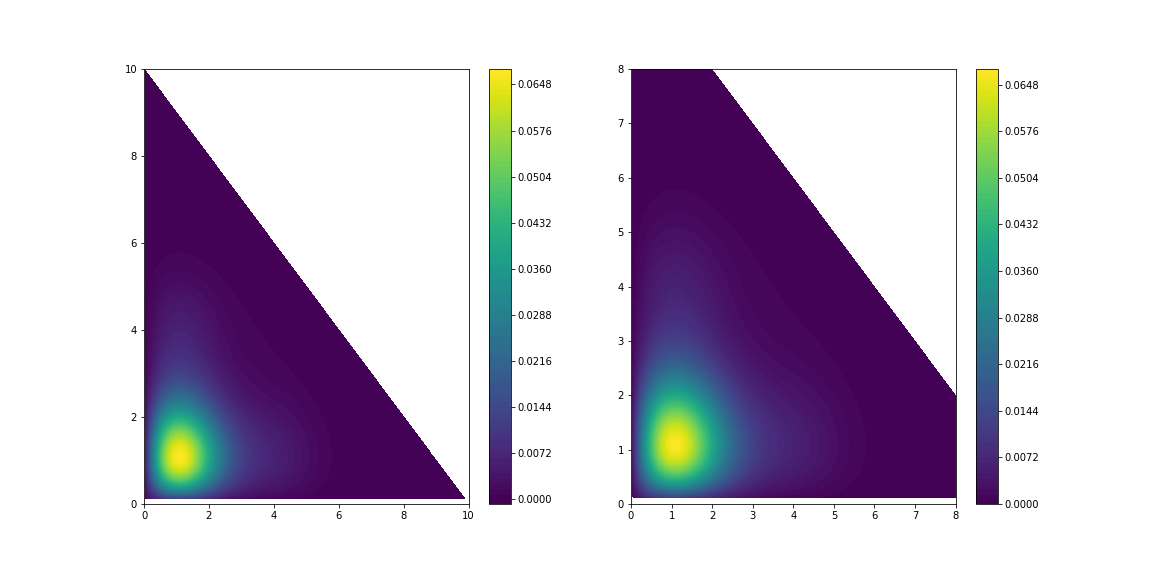

In [29]:
# # plt.plot(t_list, g_order2.real, marker='o', markersize=3)

# X, Y = np.meshgrid(, np.array(t_list)[:,1])

# plt.contour(X, Y, g_order2.real)#, marker='o', markersize=3)

y = np.array(v_list)[:,1]
x = np.array(v_list)[:,0]
z = np.abs(g_order2)

from scipy.interpolate import griddata


xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')


fig = plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
# plt.contour(xi,yi,zi,linewidths=0.5,colors='k', vmin=z.min(), vmax=z.max())
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar
# plot data points.
# plt.scatter(x,y,marker='o',c='y', s=0.1)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
# plt.title('griddata test (%d points)' % npts)

plt.subplot(1,2,2)

y = np.array(v_list)[:,1]
x = np.array(v_list)[:,0]
z = 2 *  g_order2_w #/ np.abs(g_order2)
print(z)
print(len(x), len(y), len(z))
from scipy.interpolate import griddata

xi = np.linspace(0.0,8.0,500)
yi = np.linspace(0.0,8.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.contourf(xi,yi,zi, 100, )
plt.colorbar() # draw colorbar
# plt.scatter(x,y,marker='o',c='y', s=0.1)



plt.show()

## Run a Measurement

In [57]:
order = 4
computer = k_imp.ComputeChargeQ(order, 10.0, g0.param_, 10000)
N_tot = 0

In [58]:
N = 100000
computer.run(N)
N_tot += N

In [59]:
(-1j)*(-1j)**order  * computer.reduce_result() / N_tot

(-0.3646230922292073+9.703222418638418e-12j)

## Factorial vs Power Nr of Operations

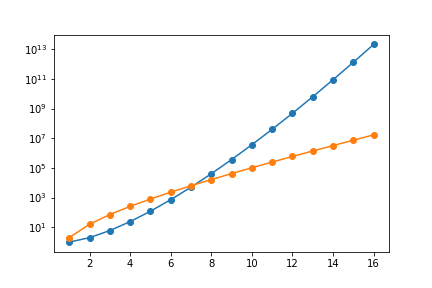

In [17]:
## Figure out exact FLOP scaling

x = np.linspace(1,16,16, dtype=int)
y_fac = map(np.math.factorial, x)#.linspace(1,10,10, dtype=int)
y_det = np.power(2, x) * np.square(x)

plt.plot(x, y_fac, marker='o')
plt.plot(x, y_det,  marker='o')
plt.yscale('log')

In [134]:
1+1

2